In [ ]:
import sys
import os

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/2025_data"))
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger"))
sys.path.append('/eos/home-d/dcostasr/SWAN_projects/software/hipy')
sys.path.append("/eos/home-d/dcostasr/SWAN_projects/software/wcte_software/")

import hipy.pltext       as pltext
import hipy.utils        as ut
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np

from src.read_data                   import load_concatenated, read_parquet, nHits
from tqdm.notebook                   import tqdm
from WCTE_event_display.EventDisplay import EventDisplay

%load_ext autoreload
%autoreload 2

pltext.style()

In [ ]:
# ============= LOADS THE DATA ===================
run  = 1726 # Ball in the center
data = load_concatenated(outdir=f"/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger/tmp_parquet/{run}")

In [ ]:
# =============== MASK OUT CARDS 130-132 ===================
run_cards, run_channels, run_slots, run_positions, run_times, run_events, run_charges = read_parquet(data, mask=True)

In [ ]:
hit_times = ak.sort(run_times)

In [ ]:
len(hit_times)

48195

In [ ]:
# # ============ nHITS TRIGGER ALGORITHM ITSELF ================================
# # ============ FIRST VERSION: 1 TRIGGER PER READOUT WINDOW ===================

# nevents = len(hit_times)
# triggered_hits_index = {}

# for event in tqdm(range(nevents), total=nevents):
#     ht = ak.to_numpy(ak.sort(hit_times[event]))
#     w = 200
#     t = 20
#     pre_window = 50
#     post_window = 100

#     # Sliding window trigger
#     starts = ht
#     ends   = ht + w
#     right  = np.searchsorted(ht, ends, side="left")
#     left   = np.arange(len(ht))
#     counts = right - left

#     # Detection of the first trigger
#     threshold_mask = (counts > t)
#     if np.any(threshold_mask):
#         trigger_index = np.where(threshold_mask)[0][0]
#         time_triggered = ht[trigger_index]

#         # Window centered in the trigger
#         t_min = time_triggered - pre_window
#         t_max = time_triggered + post_window

#         indices_in_window = np.where((ht >= t_min) & (ht < t_max))[0]
#         hits_in_window = ht[indices_in_window]

#         # print("Trigger en:", time_triggered)
#         # print("Índice del trigger:", trigger_index)
#         # print("Índices en la ventana centrada:", indices_in_window)
#         # print("Hits en la ventana centrada:", hits_in_window)
#         # print(f"Event {event} triggered")
#         triggered_hits_index[event] = indices_in_window
#     else:
#         None
#         # print(f"Event {event} did not trigger")

In [ ]:
# # Sort by number of hits in the window
# top5 = sorted(triggered_hits_index.items(), key=lambda x: len(x[1]), reverse=True)[:5]

# # Print 5 windows with the bigger amount of hits
# for i, (event_id, indices) in enumerate(top5, 1):
#     print(f"{i}. Evento {event_id} con {len(indices)} hits")

In [ ]:
# event = 243
# pltext.hist(hit_times[event][triggered_hits_index[event]], 100, ylog=True, label=f"Hits In Event {event} nHits Triggered", formate=".2e");
# pltext.hist(hit_times[event], 100, ylog=True, xylabels=("Time [ns]"), label=f"Hits In Event {event}", formate=".2e");

In [ ]:
# pltext.hist(hit_times[event][triggered_hits_index[event]], 100, ylog=False, xylabels=("Time [ns]"), label=f"Hits In Event {event} nHits Triggered", formate=".2e");

In [ ]:
# pltext.hist(hit_charges[event][triggered_hits_index[event]], 100, ylog=False, xylabels=("Charge"), label=f"Hits In Event {event} nHits Triggered", formate=".2e");

In [11]:
# ============ SECOND VERSION: AS MUCH TRIGGERS PER READOUT WINDOW AS WE FIND ===================
nevents = len(hit_times)
triggered_hits_index = {}

w = 50             # ns
t = 5              # hits
pre_window  = 50   # ns pre and post trigger window will not have an impact on number of triggers per event (500 us window, efectively 150 us)
post_window = 50   # ns
jump = 15000       # ns Trigger dead time (expected time between events)

# Run the algorithm for every readout window
for event in tqdm(range(nevents), total=nevents):
    ht = ak.to_numpy(hit_times[event])
    if len(ht) == 0: # Skip if event empty
        continue
    
    # Count hits in window
    ends   = ht + w
    right  = np.searchsorted(ht, ends, side="left")
    left   = np.arange(len(ht))
    counts = right - left

    # Get the indices of all the hit times that triggered the nHits algorithm
    trigger_indices = np.where(counts > t)[0]
    if len(trigger_indices) == 0: # Skip if no triggers in event
        continue

    event_hits = []
    last_trigger_time = -np.inf  # First trigger always need to exist

    # Search for the rest of the hits in the trigger
    for idx in trigger_indices:
        time_triggered = ht[idx]

        # If we are inside the dead time, ignore this trigger
        if time_triggered < last_trigger_time + jump:
            continue

        # Window centered in the first hit that trigger the algorithm
        t_min = time_triggered - pre_window
        t_max = time_triggered + post_window
        indices_in_window = np.where((ht >= t_min) & (ht < t_max))[0]
        event_hits.append(indices_in_window) # Append hit_times of the trigger

        # Update last valid trigger time
        last_trigger_time = time_triggered

    # Update dictionary
    if len(event_hits) > 0:
        triggered_hits_index[event] = event_hits


  0%|          | 0/48195 [00:00<?, ?it/s]

In [12]:
triggered_hits_index = nHits(hit_times, w=50, t=5, pre_window=50, post_window=50, jump=15000)

100%|██████████| 48195/48195 [00:12<00:00, 4015.72it/s]


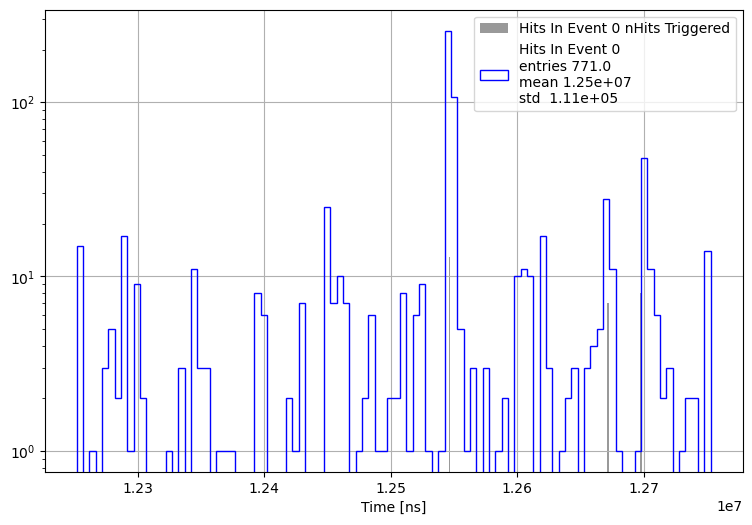

In [72]:
# Some Plots 
event = 0
triggered_hits = np.concatenate(triggered_hits_index[event])

fig = plt.figure(figsize=(9,6))
pltext.hist(hit_times[event][triggered_hits], 100, ylog=True, 
            stats=False, label=f"Hits In Event {event} nHits Triggered", formate=".2e", 
            histtype="stepfilled", alpha=0.4);
pltext.hist(hit_times[event], 100, ylog=False, xylabels=("Time [ns]"), stats=True, label=f"Hits In Event {event}", formate=".2e");

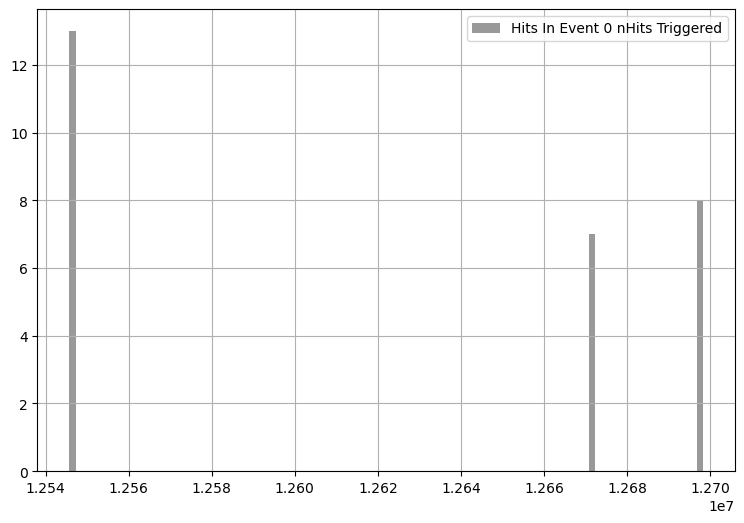

In [73]:
event = 0
triggered_hits = np.concatenate(triggered_hits_index[event])

fig = plt.figure(figsize=(9,6))
pltext.hist(hit_times[event][triggered_hits], 100, ylog=False, 
            stats=False, label=f"Hits In Event {event} nHits Triggered", formate=".2e", 
            histtype="stepfilled", alpha=0.4);

# plt.vlines(6.8+2.745266e7, 0, 50);
# plt.vlines(2.740e7+550, 0, 50);

241.8332145247273


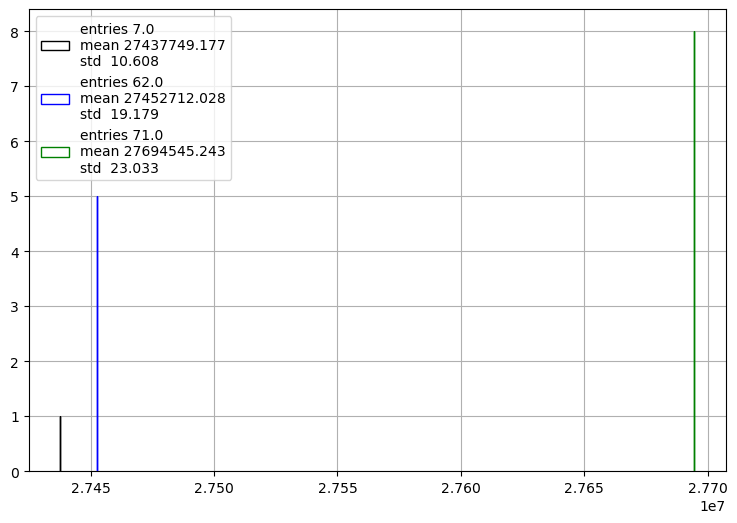

In [74]:
event = 9

fig = plt.figure(figsize=(9,6))
pltext.hist(hit_times[event][triggered_hits_index[event][0]], 100);
pltext.hist(hit_times[event][triggered_hits_index[event][1]], 100);
pltext.hist(hit_times[event][triggered_hits_index[event][2]], 100);

print((np.abs(ak.mean(hit_times[event][triggered_hits_index[event][1]]) - ak.mean(hit_times[event][triggered_hits_index[event][2]])))/1e3)

# plt.vlines(660+2.7452e7, 0, 4);
# plt.vlines(660+2.7452e7+50, 0, 4);

# plt.vlines(660+2.7452e7-50, 0, 4, color="blue");
# plt.vlines(660+2.7452e7+50+50, 0, 4, color="blue");


In [24]:
d = list(triggered_hits_index.keys())
indices = np.linspace(0, len(d) - 1, 8).astype(int)
valid_events = [d[i] for i in indices]

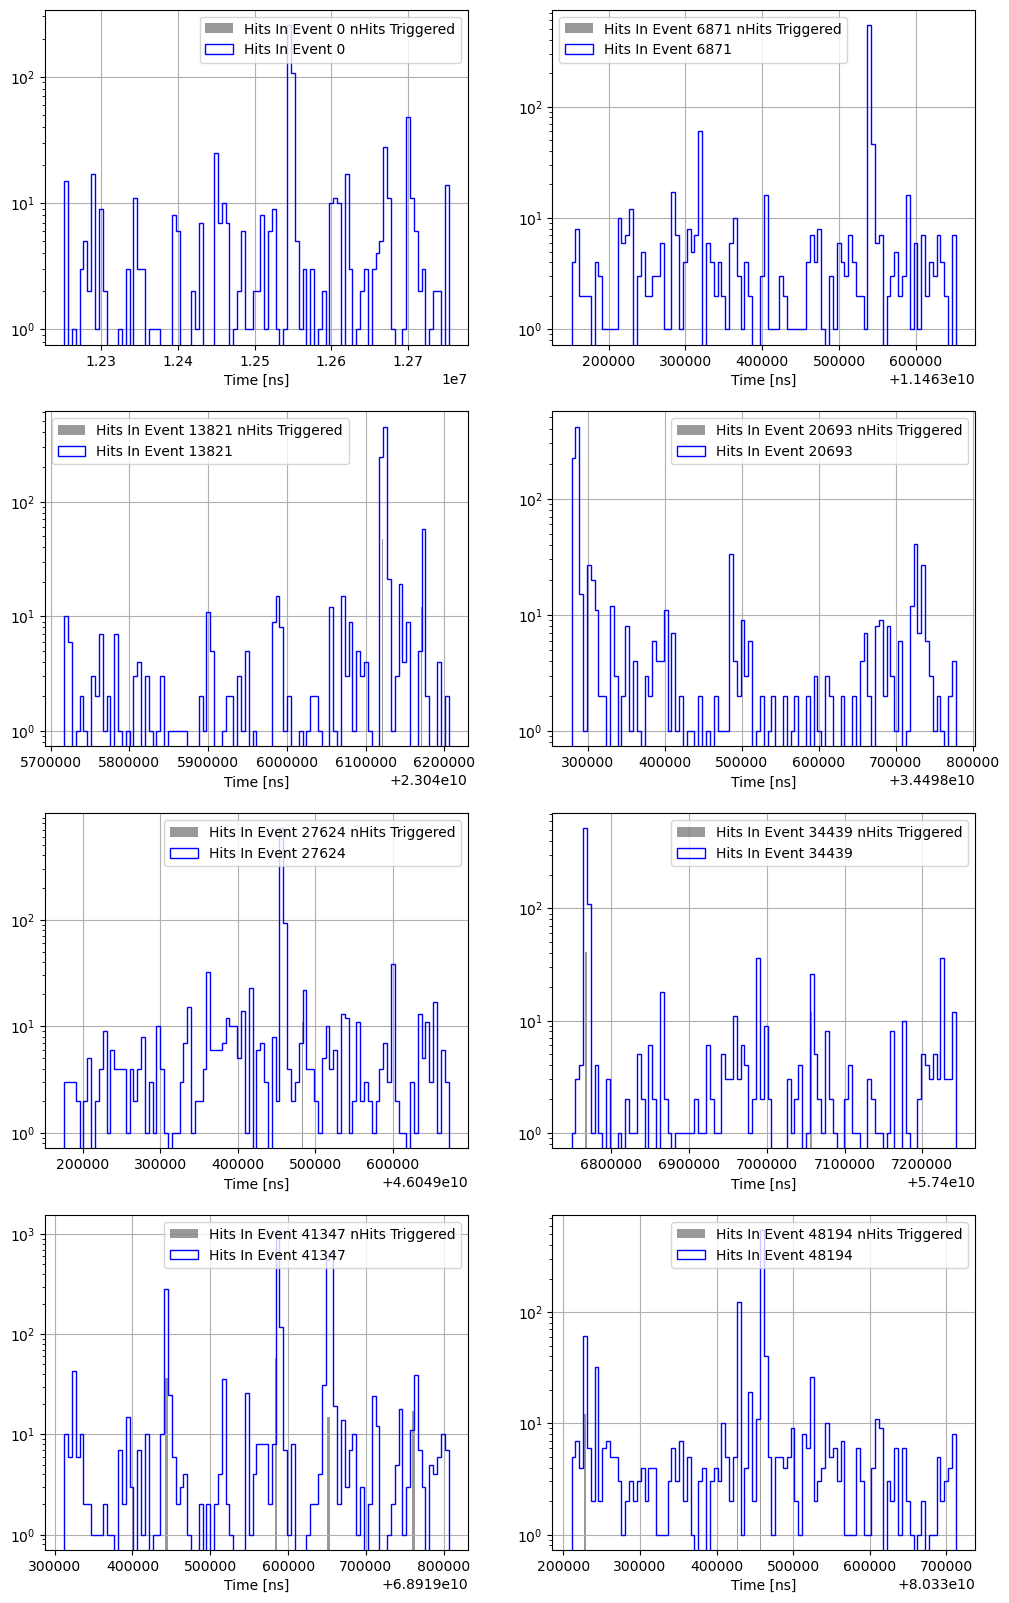

In [25]:
subplot = pltext.canvas(8)

for i, event in enumerate(valid_events):
    triggered_hits = np.concatenate(triggered_hits_index[event])
    subplot(i+1)
    pltext.hist(hit_times[event][triggered_hits], 100, ylog=True, 
                stats=False, label=f"Hits In Event {event} nHits Triggered", formate=".2e", 
                histtype="stepfilled", alpha=0.4);
    pltext.hist(hit_times[event], 100, ylog=True, xylabels=("Time [ns]"), stats=False, label=f"Hits In Event {event}", formate=".2e");

A nosa ventana é de 499.595 us


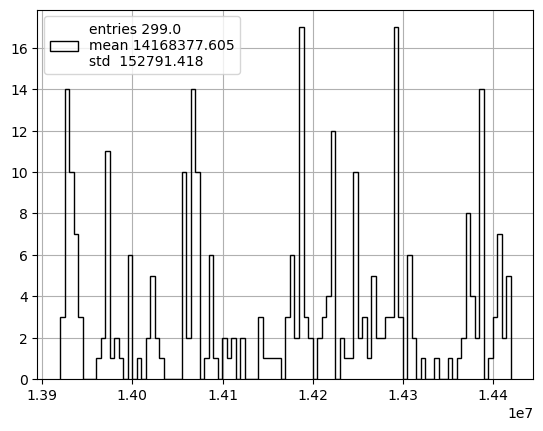

In [93]:
event = 1
pltext.hist(hit_times[event], 100);
print(f"A nosa ventana é de {round(np.abs(ak.min(hit_times[event]) - ak.max(hit_times[event])))/1e3} us")

# Number Of Triggers Per Event In Concordance With Simulation (50 ns window)

In [149]:
thresholds   = [4,5,6,7,8,9,10,11,12]
exp_values_no_upper_bound = []

for thresh in thresholds:
    triggered_hits_index = nHits(hit_times, w=50, thresh_min=thresh, thresh_max=np.inf, pre_window=50, post_window=50, jump=15000, progress_bar=False)
    noTriggers_per_event = []
    for key in triggered_hits_index.keys():
        noTriggers_per_event.append(len(triggered_hits_index.get(key)))
    
    exp_values_no_upper_bound.append(ut.stats(noTriggers_per_event)[1:3])

In [14]:
sim_entries = [405, 318, 241, 186, 147, 120, 98, 84, 73]
theo_values = [500e-6/(1/(i/1e4*3.7e5)) for i in sim_entries]

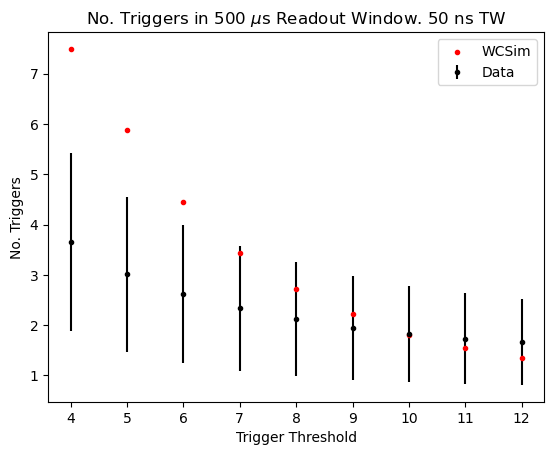

In [ ]:
# for w in range(len(windows)):
#     means = [i[0] for i in exp_values_w[w]]
#     stds  = [i[1] for i in exp_values_w[w]]
means = [i[0] for i in exp_values]
stds  = [i[1] for i in exp_values]
plt.errorbar(thresholds, means, stds, fmt=".", label=f"Data");


plt.scatter(thresholds, theo_values, marker=".", color="red", zorder=2, label="WCSim");
# plt.text(6.6, 5.4, "Trigger Window: 50 ns");

plt.xlabel("Trigger Threshold");
plt.ylabel("No. Triggers");
plt.title("No. Triggers in 500 $\mu$s Readout Window. 50 ns TW");
plt.legend();

In [83]:
triggered_hits_index_50 = nHits(hit_times, w=50, t=5, pre_window=50, post_window=50, jump=15000)
noTriggers_per_event_50 = [len(triggered_hits_index_50.get(key)) for key in triggered_hits_index_50.keys()]

triggered_hits_index_70 = nHits(hit_times, w=70, t=5, pre_window=50, post_window=50, jump=15000)
noTriggers_per_event_70 = [len(triggered_hits_index_70.get(key)) for key in triggered_hits_index_70.keys()]

triggered_hits_index_100 = nHits(hit_times, w=100, t=5, pre_window=50, post_window=50, jump=15000)
noTriggers_per_event_100 = [len(triggered_hits_index_100.get(key)) for key in triggered_hits_index_100.keys()]

100%|██████████| 48195/48195 [00:12<00:00, 3834.00it/s]


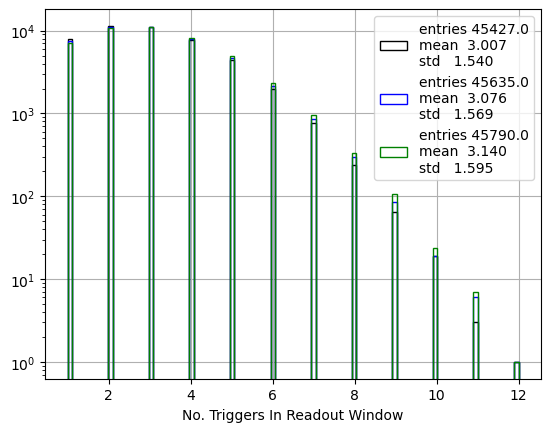

In [85]:
pltext.hist(noTriggers_per_event_50, 100, ylog=True);
pltext.hist(noTriggers_per_event_70, 100, ylog=True);
pltext.hist(noTriggers_per_event_100, 100, ylog=True);
plt.xlabel("No. Triggers In Readout Window");

# nHits Algorithm Test
As far as I can see, the algorithm works as expected.

In [115]:
test_hit_times = ak.Array([[1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9, # First Trigger
                            4.8,
                            10.0,
                            20.0,
                            100.0,
                            110.0,110.1,110.2,110.3,110.4,110.5,110.6,110.7,110.8,110.7,110.8,110.9, # Second Trigger (False because jump)
                            200.0,
                            300.0,
                            500.0,
                            600.0,
                            700.0,
                            800.0,
                            820.0,820.1,820.2,820.3,820.4,820.5,820.6,820.7,820.8,820.9, # Third Trigger
                            900.0]])

In [144]:
triggered_hits_index = nHits(test_hit_times, w=5, thresh_min=5, thresh_max=6, pre_window=0, post_window=0, jump=500, progress_bar=True)
triggered_hits_index

100%|██████████| 1/1 [00:00<00:00, 2182.26it/s]


{0: [array([ 6,  7,  8,  9, 10]), array([37, 38, 39, 40, 41])]}

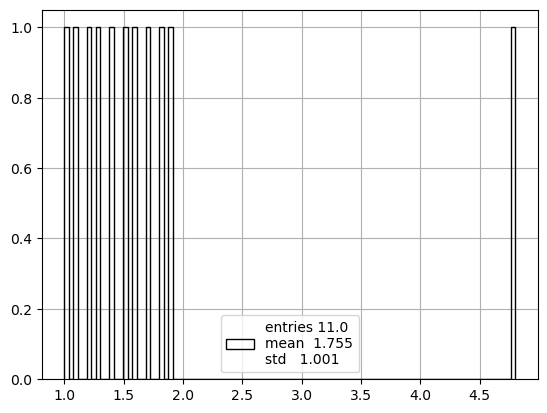

In [117]:
pltext.hist(test_hit_times[0][triggered_hits_index.get(0)[0]], 100);
# pltext.hist(test_hit_times[0][triggered_hits_index.get(0)[1]], 100);

# Cosmic Muons With nHits Trigger
In Xiaoyue's words, 50 ns should be enough in order to catch the cosmic muons since light from one cornet to the opposite one takes 20 ns, even though, I'll go with 100 ns just in case. Threshold will be 200 hits, enough to get rid of the NiCf.

In [105]:
cosmic_triggered_hits_index = nHits(hit_times, w=50, t=150, pre_window=100, post_window=150, jump=500, progress_bar=True)
cosmic_triggered_hits_index.keys()

100%|██████████| 48195/48195 [00:03<00:00, 13731.95it/s]


dict_keys([5497, 18598, 21352, 29243, 29810, 36273])

In [106]:
cosmic_hit_times = []
for key in cosmic_triggered_hits_index.keys():
    cosmic_hit_times.append(hit_times[key][np.concatenate(cosmic_triggered_hits_index.get(key))])

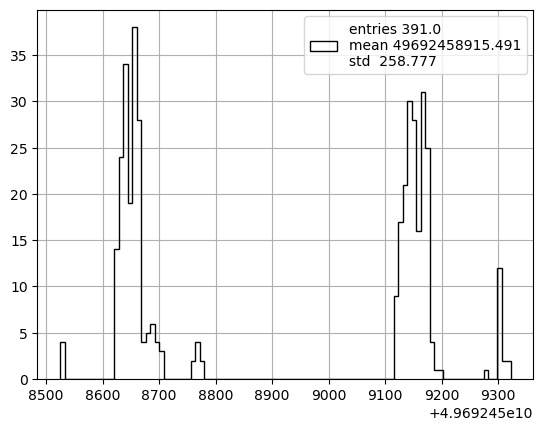

In [110]:
pltext.hist(cosmic_hit_times[4], 100);

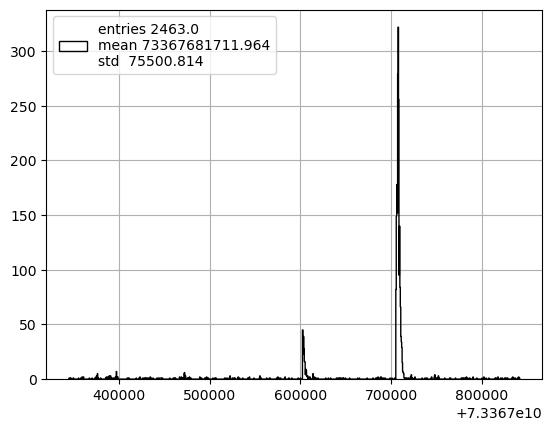

In [114]:
pltext.hist(hit_times[44016], 1000);

# NiCf Studies With Trigger Threshold Upper Bound

In [164]:
thresholds   = [4,5,6,7,8,9,10,11,12]
exp_values_upper_bound = []

for thresh in thresholds:
    triggered_hits_index = nHits(hit_times, w=50, thresh_min=thresh, thresh_max=50, pre_window=50, post_window=50, jump=10000, progress_bar=False)
    noTriggers_per_event = []
    for key in triggered_hits_index.keys():
        noTriggers_per_event.append(len(triggered_hits_index.get(key)))
    
    exp_values_upper_bound.append(ut.stats(noTriggers_per_event)[1:3])

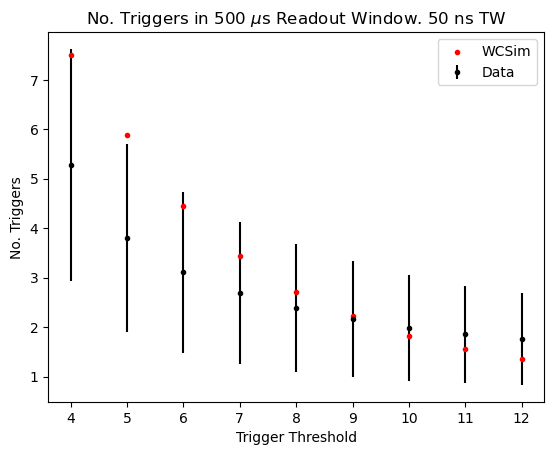

In [165]:
means_upper_bound = [i[0] for i in exp_values_upper_bound]
stds_upper_bound  = [i[1] for i in exp_values_upper_bound]

plt.errorbar(thresholds, means_upper_bound, stds_upper_bound, fmt=".", label=f"Data");
plt.scatter(thresholds, theo_values, marker=".", color="red", zorder=2, label="WCSim");
# plt.text(6.6, 5.4, "Trigger Window: 50 ns");

plt.xlabel("Trigger Threshold");
plt.ylabel("No. Triggers");
plt.title("No. Triggers in 500 $\mu$s Readout Window. 50 ns TW");
plt.legend();

In [166]:
run_times

<Array [[1.23e+07, 1.23e+07, ..., 1.26e+07], ...] type='48195 * var * float64'>

In [170]:
len(run_times)

48195

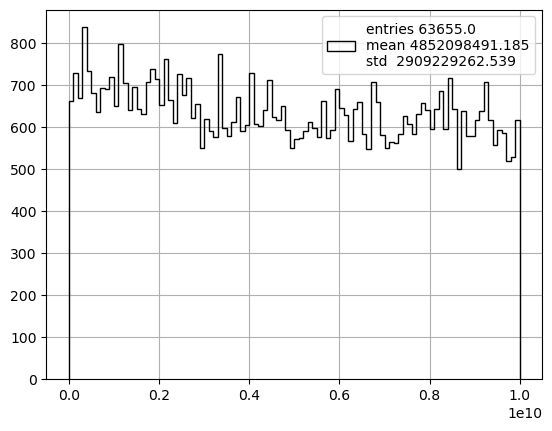

In [182]:
pltext.hist(ak.ravel(run_times[(run_cards == 84)][0:48000]), 100, range=(0,1e10));